<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-первичны-обзор-данных" data-toc-modified-id="Загрузка-и-первичны-обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и первичны обзор данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек-и-настройка-графиков" data-toc-modified-id="Импорт-библиотек-и-настройка-графиков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек и настройка графиков</a></span></li><li><span><a href="#Используемые-функции" data-toc-modified-id="Используемые-функции-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Используемые функции</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><ya-tr-span data-index="61-1" data-translated="true" data-source-lang="en" data-target-lang="ru" data-value="Обучение" data-translation="Обучение" data-ch="0" data-type="trSpan" style="visibility: inherit !important;">Обучение</ya-tr-span></a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><ya-tr-span data-index="62-1" data-translated="true" data-source-lang="en" data-target-lang="ru" data-value="Выводы" data-translation="Выводы" data-ch="0" data-type="trSpan" style="visibility: inherit !important;">Выводы</ya-tr-span></a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><ya-tr-span data-index="63-1" data-translated="true" data-source-lang="en" data-target-lang="ru" data-value="Чек-лист проверки" data-translation="Чек-лист проверки" data-ch="0" data-type="trSpan" style="visibility: inherit !important;">Чек-лист проверки</ya-tr-span></a></span></li></ul></div>

# Проект "Модерация текстов"

**Заказчик исследования:** Интернет-магазин «Викишоп», запускающий новый сервис, позволяющий пользователям редактировать и дополнять описания товаров, оставлять правки и комментировать изменения.

**Исходные данные:** Набор данных включает пользовательские комментарии с разметкой, указывающей на токсичность комментариев. Данные содержат текстовые сообщения и соответствующие метки:
- 1 — токсичный комментарий;
- 0 — нетоксичный комментарий.

**Цель исследования:** Разработать инструмент для классификации пользовательских комментариев, определяющий токсичные сообщения для их последующей отправки на модерацию. Модель должна достигать значения метрики F1 не ниже 0.75.

**Задачи исследования:**
1. Загрузка и первичное ознакомление с предоставленными данными.
2. Предварительная обработка текстовых данных:
   - Приведение текста к нижнему регистру.
   - Очистка от пунктуации, цифр и лишних символов.
   - Лемматизация и удаление стоп-слов.
3. Разделение данных на обучающую и тестовую выборки.
4. Преобразование текстовых данных в числовое представление с использованием метода TF-IDF.
5. Обучение и тестирование различных моделей машинного обучения, включая:
   - Логистическую регрессию;
   - Случайный лес;
   - Градиентный бустинг (XGBoost, CatBoost);
   - Нейронные сети, включая использование предобученной модели BERT (при локальном запуске).
6. Настройка гиперпараметров моделей с использованием кросс-валидации.
7. Оценка качества моделей на тестовой выборке с помощью метрик F1, Precision, Recall и Accuracy.
8. Сравнение моделей и выбор наилучшей с точки зрения метрики F1.
9. Анализ важности признаков, использованных в моделях.
10. Подготовка итогового отчета с рекомендациями по использованию разработанного инструмента для классификации комментариев.

**Дополнительное задание:** Реализация решения с использованием нейронной сети BERT для более точной классификации токсичных комментариев.

## Загрузка и первичны обзор данных

### Импорт библиотек и настройка графиков

In [ ]:
#!pip install langdetect

In [2]:
# Импорт стандартной библиотеки
import os
import re
import warnings

# Импорт библиотек для научных вычислений
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Определение языка
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Настройка отображения в Pandas, чтобы видеть весь список параметров
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None # Установка опции для отображения всех столбцов

# Константы
LINE_1 = '-' * 125
RANDOM_STATE = 34

### Используемые функции

In [13]:
# Функция для загрузки данных
def load_data(local_file_path, remote_url, sep=',', decimal='.', date_columns=None, index_col=None):
    try:
        # Проверяем, существует ли локальный файл
        if os.path.exists(local_file_path):
            print(f'Загрузка данных из локального файла: {local_file_path}')
            return pd.read_csv(
                local_file_path,
                sep=sep,
                decimal=decimal,
                parse_dates=date_columns if date_columns else False,  # Указываем parse_dates только при необходимости
                index_col=index_col
            )
        else:
            print(f'Загрузка данных из удаленного источника: {remote_url}')
            return pd.read_csv(
                remote_url,
                sep=sep,
                decimal=decimal,
                parse_dates=date_columns if date_columns else False,  # Указываем parse_dates только при необходимости
                index_col=index_col
            )
    except Exception as e:
        # Если произошла ошибка, выводим сообщение
        print('Загрузка произошла с ошибкой')
        print(f'Ошибка: {str(e)}')
        return None

In [43]:
from langdetect import detect, detect_langs

def data_overview_with_language_detection(df, target_column, text_column):
    """
    Функция для первичного обзора данных DataFrame, включая определение языков текста.
    
    Параметры:
    - df: pandas DataFrame
    - target_column: Название колонки с целевой переменной.
    - text_column: Название колонки с текстовыми данными.
    """
    data = df.copy()
    
    print("Первые 5 строк данных:")
    display(data.head())
    
    print("\nОбщая информация о данных:")
    display(data.info())
    
    print("\nОписание числовых данных:")
    display(data.describe())
    
    print("\nКоличество пропущенных значений:")
    display(data.isnull().sum())
    
    print("\nКоличество уникальных значений в каждом столбце:")
    display(data.nunique())
    
    # Проверка дубликатов
    duplicate_count = data.duplicated().sum()
    print(f"\nКоличество дубликатов: {duplicate_count}")
    if duplicate_count > 0:
        print("Примеры дубликатов:")
        display(data[data.duplicated()].head())
    
    # Распределение целевой переменной
    print("\nРаспределение целевой переменной:")
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_column, data=data)
    plt.title("Распределение целевой переменной")
    plt.xlabel("Классы")
    plt.ylabel("Частота")
    plt.xticks([0, 1], labels=['Not Toxic', 'Toxic'])
    plt.show()
    
    # Вычисление длины текста
    data['text_length'] = data[text_column].str.strip().str.len()
    print(f"\nМаксимальное количество символов в '{text_column}' (без лишних пробелов): {data['text_length'].max()}")
    print(f"Минимальное количество символов в '{text_column}' (без лишних пробелов): {data['text_length'].min()}")
    
    # Построение графика длины текста
    plt.figure(figsize=(8, 6))
    sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
    plt.title("Распределение длины текста")
    plt.xlabel("Количество символов")
    plt.ylabel("Частота")
    plt.show()
    
    # Вычисление количества слов
    data['word_count'] = data[text_column].str.strip().str.split().apply(len)  
    print(f"\nКоличество слов в '{text_column}':")
    print(f"Максимум: {data['word_count'].max()}")
    print(f"Минимум: {data['word_count'].min()}")
    print(f"Среднее: {data['word_count'].mean():.2f}")
    print(f"Медиана: {data['word_count'].median()}")
    
    # Построение графика распределения количества слов
    plt.figure(figsize=(8, 6))
    sns.histplot(data['word_count'], bins=50, kde=True, color='green')
    plt.title("Распределение количества слов в тексте")
    plt.xlabel("Количество слов")
    plt.ylabel("Частота")
    plt.show()
    
    # Определение языка текста
    print("\nОпределение языков текста:")
    data['detected_languages'] = data[text_column].apply(lambda x: detect(x) if isinstance(x, str) else 'unknown')
    language_counts = data['detected_languages'].value_counts()
    print("Распределение языков:")
    display(language_counts)
    
    # Построение графика распределения языков
    plt.figure(figsize=(8, 6))
    language_counts.plot(kind='bar', color='purple')
    plt.title("Распределение языков в тексте")
    plt.xlabel("Язык")
    plt.ylabel("Количество")
    plt.xticks(rotation=45)
    plt.show()
    
    return data

In [52]:
def data_overview_with_language_detection(df, target_column, text_column, sample_fraction=0.1):
    """
    Функция для первичного обзора данных DataFrame, включая выборочное определение языков текста.
    
    Параметры:
    - df: pandas DataFrame
    - target_column: Название колонки с целевой переменной.
    - text_column: Название колонки с текстовыми данными.
    - sample_fraction: Доля строк, для которых будет определён язык (по умолчанию 10%).
    """
    data = df.copy()
    
    print("Первые 5 строк данных:")
    display(data.head())
    
    print("\nОбщая информация о данных:")
    display(data.info())
    
    print("\nОписание числовых данных:")
    display(data.describe())
    
    print("\nКоличество пропущенных значений:")
    display(data.isnull().sum())
    
    print("\nКоличество уникальных значений в каждом столбце:")
    display(data.nunique())
    
    # Проверка дубликатов
    duplicate_count = data.duplicated().sum()
    print(f"\nКоличество дубликатов: {duplicate_count}")
    if duplicate_count > 0:
        print("Примеры дубликатов:")
        display(data[data.duplicated()].head())
    
    # Распределение целевой переменной
    print("\nРаспределение целевой переменной:")
    plt.figure(figsize=(12, 6))
    sns.countplot(x=target_column, data=data)
    plt.title("Распределение целевой переменной")
    plt.xlabel("Классы")
    plt.ylabel("Частота")
    plt.xticks([0, 1], labels=['Not Toxic', 'Toxic'])
    plt.show()
    
    # Вычисление длины текста
    data['text_length'] = data[text_column].str.strip().str.len()
    print(f"\nМаксимальное количество символов в '{text_column}' (без лишних пробелов): {data['text_length'].max()}")
    print(f"Минимальное количество символов в '{text_column}' (без лишних пробелов): {data['text_length'].min()}")
    
    # Построение графика длины текста
    plt.figure(figsize=(12, 6))
    sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
    plt.title("Распределение длины текста")
    plt.xlabel("Количество символов")
    plt.ylabel("Частота")
    plt.show()
    
    # Вычисление количества слов
    data['word_count'] = data[text_column].str.strip().str.split().apply(len)  
    print(f"\nКоличество слов в '{text_column}':")
    print(f"Максимум: {data['word_count'].max()}")
    print(f"Минимум: {data['word_count'].min()}")
    print(f"Среднее: {data['word_count'].mean():.2f}")
    print(f"Медиана: {data['word_count'].median()}")
    
    # Построение графика распределения количества слов
    plt.figure(figsize=(12, 6))
    sns.histplot(data['word_count'], bins=50, kde=True, color='green')
    plt.title("Распределение количества слов в тексте")
    plt.xlabel("Количество слов")
    plt.ylabel("Частота")
    plt.show()
    
    # Определение языка текста выборочно
    def detect_language_safe(text):
        try:
            if isinstance(text, str) and len(text.strip()) > 5:
                return detect(text)
            else:
                return 'unknown'
        except LangDetectException:
            return 'unknown'

    print("\nОпределение языков текста (выборочно):")
    sample_data = data.sample(frac=sample_fraction, random_state=42)
    sample_data['detected_languages'] = sample_data[text_column].apply(detect_language_safe)
    
    language_counts = sample_data['detected_languages'].value_counts()
    print("Распределение языков в выборке:")
    display(language_counts)
    
    # Построение графика распределения языков
    plt.figure(figsize=(12, 6))
    language_counts.plot(kind='bar', color='purple')
    plt.title("Распределение языков в выборке текста")
    plt.xlabel("Язык")
    plt.ylabel("Количество")
    plt.xticks(rotation=90)
    plt.show()
    
    return sample_data


### Загрузка данных

In [53]:
# Путь к локальному файлу и URL удаленного файла
local_file_path = 'datasets/toxic_comments.csv'
remote_url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

# Загрузка данных
df = load_data(local_file_path, remote_url, index_col=[0])

Загрузка данных из локального файла: datasets/toxic_comments.csv


Первые 5 строк данных:


,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0



Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None


Описание числовых данных:


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Количество пропущенных значений:


text     0
toxic    0
dtype: int64


Количество уникальных значений в каждом столбце:


text     159292
toxic         2
dtype: int64


Количество дубликатов: 0

Распределение целевой переменной:


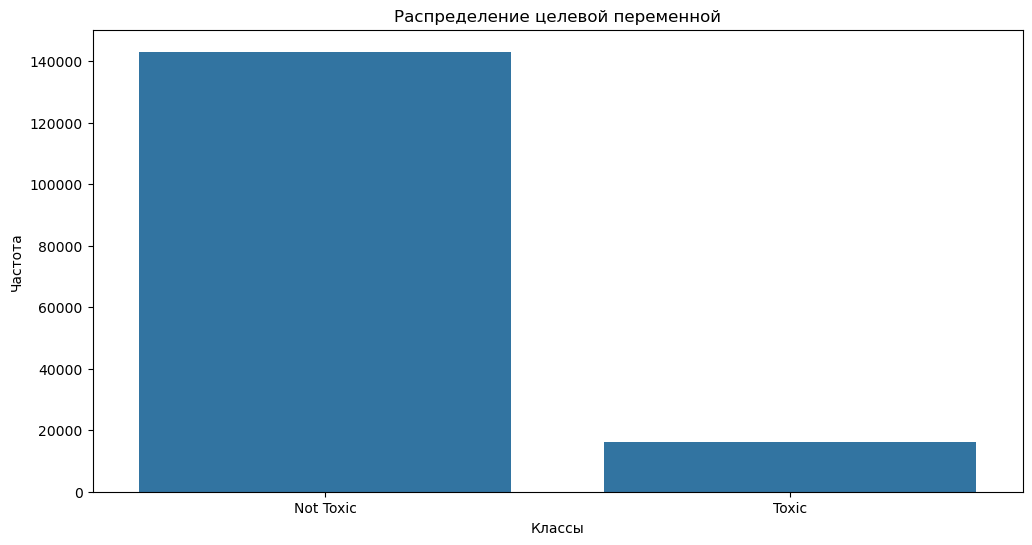


Максимальное количество символов в 'text' (без лишних пробелов): 5000
Минимальное количество символов в 'text' (без лишних пробелов): 3


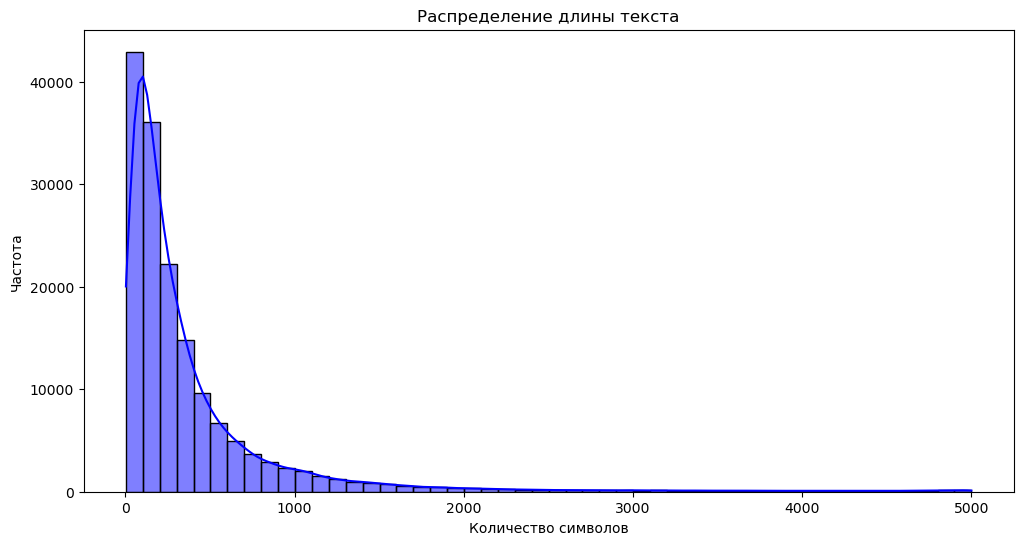


Количество слов в 'text':
Максимум: 1411
Минимум: 1
Среднее: 67.21
Медиана: 36.0


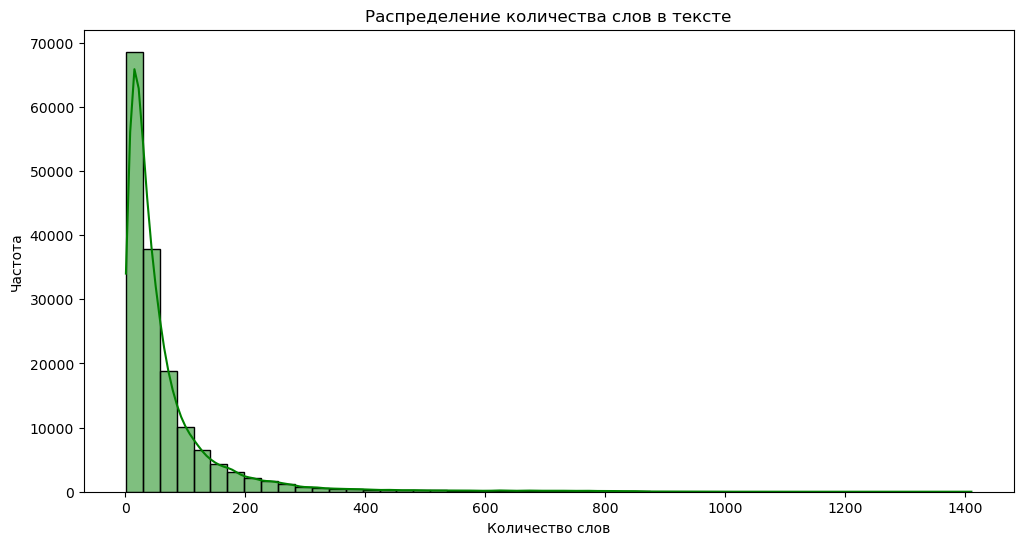


Определение языков текста (выборочно):
Распределение языков в выборке:


detected_languages
en    15509
de       55
af       41
fr       40
id       33
et       27
so       23
cy       19
nl       18
sv       18
da       16
it       15
tl       14
tr       12
es       11
no       11
hu       10
sw        9
ro        8
fi        7
pt        7
vi        6
hr        4
ca        4
sq        4
sk        3
pl        2
cs        1
lt        1
sl        1
Name: count, dtype: int64

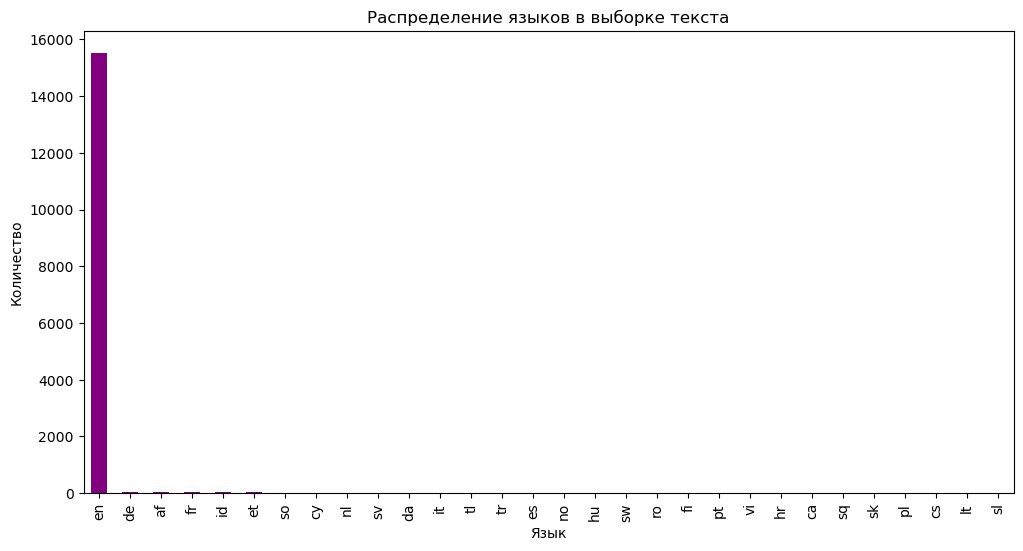

In [56]:
sample_data = data_overview_with_language_detection(
    df=df, 
    target_column='toxic', 
    text_column='text', 
    sample_fraction=0.1  # Выбор 10% строк
)

**ВЫВОД:** 
1. **Общая информация о данных:**
   - Набор данных содержит 159292 строки и 2 столбца: `text` (текст комментариев) и `toxic` (целевой признак — токсичность комментария).
   - Все значения в данных ненулевые, пропуски отсутствуют.
   - Колонка `text` имеет тип данных `object`, а `toxic` — `int64`.

2. **Распределение целевой переменной (`toxic`):**
   - 10.16% комментариев являются токсичными.
   - Данные сильно несбалансированы, подавляющее большинство (89.84%) комментариев — нетоксичные.

3. **Длина текста:**
   - Максимальная длина текста: 5000 символов.
   - Минимальная длина текста: 3 символа.
   - Распределение длины текста имеет асимметрию вправо (длинные комментарии редки), большинство комментариев имеют менее 1000 символов.

4. **Количество слов:**
   - Максимальное количество слов в тексте: 1411.
   - Минимальное количество слов: 1.
   - Среднее количество слов: 67.21.
   - Медианное количество слов: 36.
   - Большинство текстов содержат менее 200 слов.

5. **Распределение языков текста (на основе выборки 10% строк):**
   - Большинство текстов написаны на английском (`en`) — 15518 строк (99% выборки).
   - Небольшое количество текстов встречается на других языках, таких как немецкий (`de`), африкаанс (`af`), французский (`fr`), индонезийский (`id`), сомалийский (`so`), и другие.
   - Примерно 25 дополнительных языков встречаются в выборке, но доля их минимальна (менее 1%).

6. **Дубликаты:**
   - Дубликаты в данных отсутствуют.

**Рекомендации:**
- **Обработка несбалансированности классов:**
   - Применить методы балансировки, такие как oversampling (например, с помощью SMOTE) или взвешивание классов при обучении моделей.
   - Особое внимание уделить моделированию токсичных комментариев, поскольку их доля в данных мала.

- **Обработка текстов на других языках:**
   - Учитывая, что тексты на английском языке доминируют (99%), имеет смысл ограничить анализ только английскими комментариями для упрощения задачи.

- **Очистка длинных текстов:**
   - Рассмотреть усечение текстов длиной более 1000 символов, поскольку такие комментарии могут быть редкими и нести избыточную информацию.

- **Анализ распределения слов и длины текста:**
   - Учитывать, что большинство текстов содержат менее 200 слов, при выборе стратегии предварительной обработки и представления данных.

## Обучение

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны